In [1]:
import os
from pathlib import Path
import sys
curdir = Path(os.getcwd())
sys.path.append(str(curdir.parent.absolute()))
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from src.utils.data import read_fasta
from src.data.datasets import ProteinDataset
import numpy as np
from src.utils.data import read_pickle
from src.utils.evaluation import metrics_per_label_df
import seaborn as sns
import torch
from torchmetrics.classification import AveragePrecision,Specificity

/anaconda/envs/protein_functions_310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train = read_fasta('../data/swissprot/proteinfer_splits/random/train_GO.fasta')
val = read_fasta('../data/swissprot/proteinfer_splits/random/dev_GO.fasta')
test = read_fasta('../data/swissprot/proteinfer_splits/random/test_GO.fasta')

In [3]:
train = [(k[0],j," ".join(k[1:]),'train') for j,k in train]
test = [(k[0],j," ".join(k[1:]),'val') for j,k in test]
val = [(k[0],j," ".join(k[1:]),'test') for j,k in val]

df = train + val + test

In [4]:
df = pd.DataFrame(df,columns=['id','sequence','labels','split'])

In [5]:
num_sequences = len(df)
print('number of sequences:',num_sequences)

number of sequences: 522607


In [6]:
df.head()

,id,sequence,labels,split
0,P60545,MSKIIEYDETARRAIEAGVNTLADAVRVTLGPRGRHVVLAKAFGGP...,GO:0035639 GO:0032553 GO:0005524 GO:0017076 GO...,train
1,Q3KEX7,MKFSEQWLRGWVSPQVDRDALVARLSMAGLEVDSVTPAAGVFSGVV...,GO:0016070 GO:0035639 GO:0004812 GO:0032553 GO...,train
2,Q8D2U1,MKSVSIIDIIEKKIFKKKLVEINGWVRTKRNSKLGISFVDVYDGSC...,GO:0016070 GO:0004812 GO:0035639 GO:0032553 GO...,train
3,Q95KN1,MKPSLLVFTVYLLWLKDCHCAPTWKDKTDMHGNLKGFSEAGDIDVD...,GO:0044424 GO:0003674 GO:0044464 GO:0043226 GO...,train
4,Q98HL0,MNSLDLPGRPENTRIVVAMSGGVDSSVVAGLLKREGYDVVGVTLQL...,GO:0016070 GO:0035639 GO:0032553 GO:0005524 GO...,train


In [7]:
df['num_pos'] = df['labels'].str.split(' ').str.len()
df['num_pos'].describe()

count    522607.000000
mean         47.743901
std          38.433523
min           2.000000
25%          25.000000
50%          43.000000
75%          59.000000
max        1008.000000
Name: num_pos, dtype: float64

In [8]:
labels = Counter()

vocab = set()
amino_freq = Counter()
for idx,row in df[df['split']=='train'].iterrows():
    sequence = row['sequence']
    row_labels = row['labels']
    aa_list = list(sequence)
    if row_labels =='':
        print(row['id'],row['labels'])
    vocab.update(aa_list)
    amino_freq.update(aa_list)
    labels.update(row_labels.split(" "))

In [9]:
print('# GO Terms:',len(labels.keys()))

# GO Terms: 31365


In [10]:
print('GO Terms distribution')
go_term_distribution = pd.Series(labels.values(),index=labels.keys()).sort_values(ascending=False)
go_term_distribution.describe()

GO Terms distribution


count     31365.000000
mean        635.987821
std        7372.964658
min           1.000000
25%           4.000000
50%          14.000000
75%          70.000000
max      369909.000000
dtype: float64

In [11]:
go_term_distribution

GO:0003674    369909
GO:0008150    346677
GO:0005575    321980
GO:0009987    295442
GO:0044464    291432
               ...  
GO:1903890         1
GO:0102632         1
GO:0010059         1
GO:0072616         1
GO:0030787         1
Length: 31365, dtype: int64

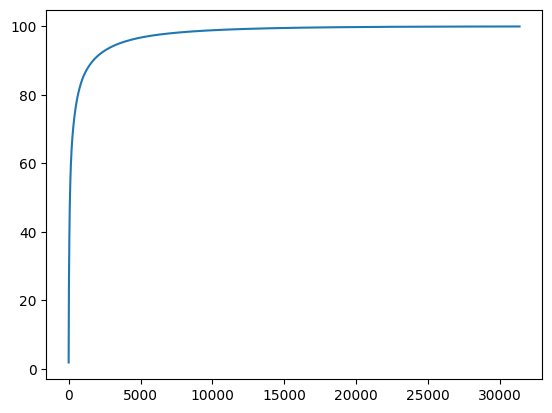

In [12]:
# Cumulative distribution of GO terms. Shows the number of GO terms that cover X% of the data
plt.plot(range(len(go_term_distribution)),(go_term_distribution*100/go_term_distribution.sum()).cumsum())

In [13]:
print('Sequence length distribution')

df['sequence'].apply(len).describe()

Sequence length distribution


count    522607.000000
mean        368.042215
std         334.721845
min           2.000000
25%         179.000000
50%         303.000000
75%         456.000000
max       35213.000000
Name: sequence, dtype: float64

# Explore Model Predictions

In [14]:
#Read Val Data
val_labels = pd.read_parquet("../outputs/results/final_validation_labels_fl_mlpscale2_projection_head_2layers.parquet")
val_logits = pd.read_parquet("../outputs/results/final_validation_logits_fl_mlpscale2_projection_head_2layers.parquet")
pinf_val_logits = pd.read_parquet('../outputs/results/validation_logits_proteinfer.parquet')
pinf_val_labels= pd.read_parquet('../outputs/results/validation_labels_proteinfer.parquet')


In [15]:
label_descriptions = pd.read_pickle('../data/annotations/go_annotations_2019_07_01.pkl')
label_descriptions = label_descriptions.loc[go_term_distribution.index]

In [16]:
label_descriptions['label'] = label_descriptions['label'].str.lower().str.rstrip()

In [17]:
val_labels.shape,pinf_val_logits.shape

((44352, 32102), (44300, 32102))

In [17]:
#Common ids.. They should all be common but there are 60 sequences more in our dataset
#Crate Tensor versions

common_seqids = list(set(val_labels.index) & set(pinf_val_labels.index))


val_logits = val_logits.loc[common_seqids]
val_labels = val_labels.loc[common_seqids]
pinf_val_logits = pinf_val_logits.loc[common_seqids]
pinf_val_labels = pinf_val_labels.loc[common_seqids]

val_logits_t = torch.tensor(val_logits.values)
val_labels_t = torch.tensor(val_labels.values).float()
val_probabilities_t = torch.sigmoid(val_logits_t)

pinf_val_logits_t = torch.tensor(pinf_val_logits.values)
pinf_val_labels_t = torch.tensor(pinf_val_labels.values).float()
pinf_val_probabilities_t = torch.sigmoid(pinf_val_logits_t)

val_probabilities = pd.DataFrame(val_probabilities_t.numpy(),columns=val_logits.columns,index=val_logits.index)
pinf_val_probabilities = pd.DataFrame(pinf_val_probabilities_t.numpy(),columns=pinf_val_logits.columns,index=pinf_val_logits.index)

In [18]:
val_logits_t = torch.tensor(val_logits.values)
val_labels_t = torch.tensor(val_labels.values).float()
val_probabilities_t = torch.sigmoid(val_logits_t)

pinf_val_logits_t = torch.tensor(pinf_val_logits.values)
pinf_val_labels_t = torch.tensor(pinf_val_labels.values).float()
pinf_val_probabilities_t = torch.sigmoid(pinf_val_logits_t)

val_probabilities = pd.DataFrame(val_probabilities_t.numpy(),columns=val_logits.columns,index=val_logits.index)
pinf_val_probabilities = pd.DataFrame(pinf_val_probabilities_t.numpy(),columns=pinf_val_logits.columns,index=pinf_val_logits.index)

In [68]:
cooc = val_labels_t.T@val_labels_t

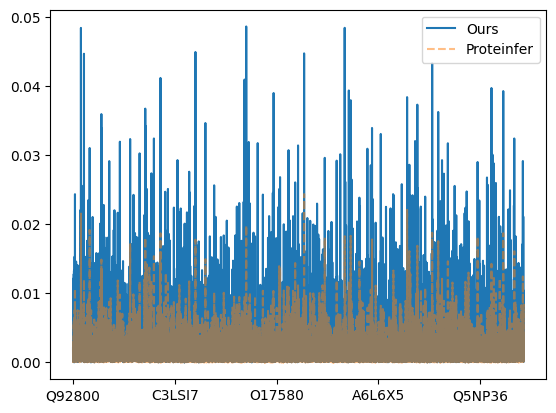

In [20]:
val_probabilities.mean(axis=1).plot(label='Ours')
pinf_val_probabilities.mean(axis=1).plot(label='Proteinfer',alpha=0.5,linestyle='--')
plt.legend()

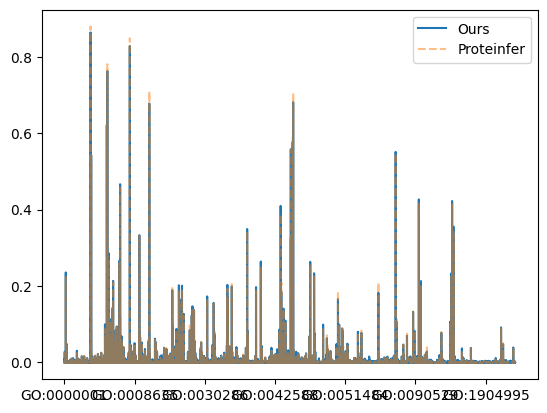

In [21]:
val_probabilities.mean(axis=0).plot(label='Ours')
pinf_val_probabilities.mean(axis=0).plot(label='Proteinfer',alpha=0.5,linestyle='--')
plt.legend()

In [22]:
pd.DataFrame(val_probabilities.mean(axis=0)).corrwith(pd.DataFrame(pinf_val_probabilities.mean(axis=0)),axis=0)

0    0.997824
dtype: float64

In [23]:
sequence_dist_corr = pinf_val_probabilities.corrwith(val_probabilities,axis=1)
label_dist_corr = pinf_val_probabilities.corrwith(val_probabilities,axis=0)

<Axes: >

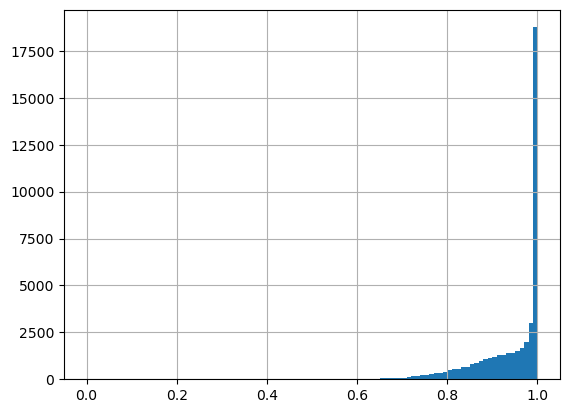

In [25]:
sequence_dist_corr.hist(bins=100)

<Axes: >

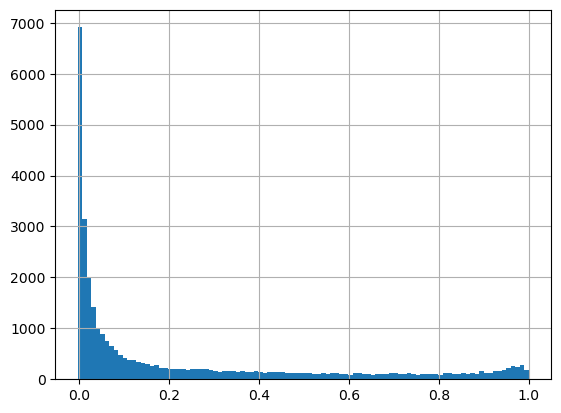

In [26]:
label_dist_corr.hist(bins=100)

<Axes: >

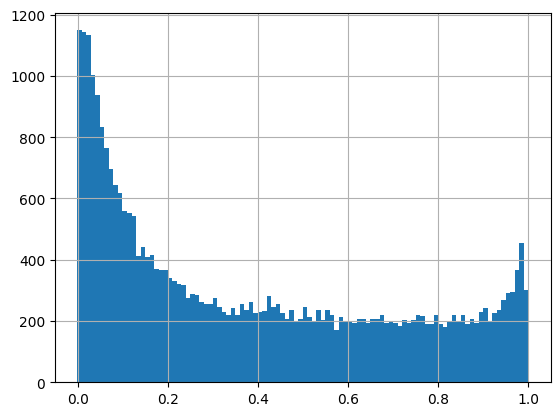

In [25]:
label_dist_corr.hist(bins=100)

Compare losses

In [18]:
import torch
from src.utils.losses import FocalLoss

bce_probs = torch.nn.BCELoss(reduction='none')
bce = torch.nn.BCEWithLogitsLoss(reduction='none')
fl = FocalLoss(alpha=-1,gamma=3,reduction='none')


In [19]:
#BCE Loss
ours_val_bce_losses = bce(torch.tensor(val_logits.values), torch.tensor(val_labels.values).float())
pinf_val_bce_losses = bce(torch.tensor(pinf_val_logits.values), torch.tensor(pinf_val_labels.values).float())
pinf_val_bce_losses.mean(),ours_val_bce_losses.mean()

(tensor(0.0036), tensor(0.0020))

In [20]:
#Focal Loss

ours_val_bce_losses = fl(torch.tensor(val_logits.values), torch.tensor(val_labels.values).float())
pinf_val_bce_losses = fl(torch.tensor(pinf_val_logits.values), torch.tensor(pinf_val_labels.values).float())
pinf_val_bce_losses.mean(),ours_val_bce_losses.mean()

(tensor(0.0035), tensor(0.0015))

Random model baseline losses

In [127]:
random_model_bce = bce_probs(torch.ones_like(val_labels_t)*0.5, val_labels_t)
random_model_fl =fl(torch.ones_like(val_labels_t)*0.5, val_labels_t)
random_model_bce.mean(),random_model_fl.mean()

(tensor(0.6931), tensor(0.2346))

Always predict 1/672 = probability of positive in the dataset

In [128]:
always_negative_preds = torch.ones_like(val_labels_t)/672
predict_0_model_bce = bce_probs(always_negative_preds, val_labels_t)
predict_0_model_fl = fl(always_negative_preds, val_labels_t)

predict_0_model_bce.mean(),predict_0_model_fl.mean()


(tensor(0.0113), tensor(0.0869))

In [129]:
always_negative_preds = torch.ones_like(val_labels_t)/672
always_random = torch.ones_like(val_labels_t)*.5

Baseline top classes

In [37]:
n = 1000
predict_top_classes = val_probabilities.copy()
top_n = go_term_distribution[:n].index
predict_top_classes.iloc[:,:] = 0.0
for col in top_n:
    predict_top_classes[col]=0.9
predict_top_classes = torch.tensor(predict_top_classes.values).float()

predict_top_classes_bce = bce_probs(predict_top_classes, val_labels_t)
predict_top_classes_fl = fl(predict_top_classes, val_labels_t)

predict_top_classes_bce.mean(),predict_top_classes_fl.mean()

(tensor(0.0927), tensor(0.0973))

In [28]:
res=metrics_per_label_df(val_labels,val_probabilities,device='cuda',threshold=threshold)


100%|██████████| 21804/21804 [01:53<00:00, 192.62it/s]


In [19]:
#Define threshold to calculate threshold-dependent metrics otherwise only threshold-agnostic metrics are calculated
threshold = None
res=metrics_per_label_df(val_labels,val_probabilities,device='cuda',threshold=threshold)
pinf_res=metrics_per_label_df(pinf_val_labels,pinf_val_probabilities,device='cuda',threshold=threshold)

  2%|▏         | 363/21791 [00:01<01:29, 238.40it/s]


KeyboardInterrupt: 

In [26]:
from src.utils.evaluation import EvalMetrics

eval_metrics = EvalMetrics(device='cuda:0')
metrics = eval_metrics.get_metric_collection_with_regex(pattern="f1_m.*", threshold=0.5,
                                                                num_labels=32102
                                                                )

In [29]:
a=metrics(val_probabilities_t.to('cuda:0'),val_labels_t.to('cuda:0'))

In [30]:
a

{'f1_macro': tensor(0.2177, device='cuda:0'),
 'f1_micro': tensor(0.8603, device='cuda:0')}

In [23]:
res["F1"].fillna(0).mean()

0.29680396842793894

In [29]:
res["AUPRC"].dropna().mean(),pinf_res["AUPRC"].dropna().mean()

(0.45503900507782646, 0.6516080107543541)

In [30]:
res['F1'].mean(),pinf_res['F1'].mean()

(0.4369847616377259, 0.6446110922796205)

In [31]:
res['AUPRC'].fillna(0).mean()

0.30906705086028685

In [38]:
res['model']='Ours'
pinf_res['model']='Proteinfer'

In [39]:
res=pd.concat([res,pinf_res],axis=0)

In [40]:
res = res.drop(["Frequency","Relative Frequency"],axis=1)

In [41]:
res["Frequency"] = res.index.map(go_term_distribution)

In [42]:
res.to_parquet("model_comparison_auprc_per_label.parquet")

/anaconda/envs/protein_functions_310/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


In [43]:
res[res['model']=='Ours'].shape

(32102, 3)

<Axes: xlabel='AUPRC', ylabel='Count'>

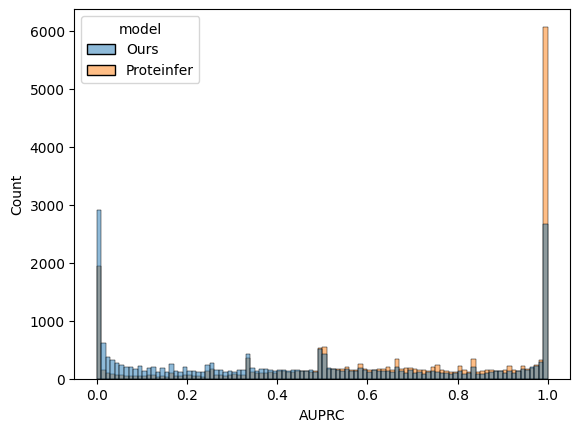

In [44]:
sns.histplot(data = res.reset_index(),x='AUPRC',hue='model',bins=100)

In [45]:
res_pivot = res.pivot(columns=['model'],values=['AUPRC','Frequency'])

In [46]:
res_pivot.columns = [i[0]+'_'+i[1] for i in res_pivot.columns]

In [47]:
ours_better = res_pivot[res_pivot['AUPRC_Ours']>res_pivot['AUPRC_Proteinfer']].sort_values(by='Frequency_Ours',ascending=False)

In [29]:
ours_better

,AUPRC_Ours,AUPRC_Proteinfer,Frequency_Ours,Frequency_Proteinfer
GO:0003674,0.997007,0.994481,369909.0,369909.0
GO:0008150,0.991259,0.983664,346677.0,346677.0
GO:0005575,0.994247,0.992867,321980.0,321980.0
GO:0009987,0.986008,0.980420,295442.0,295442.0
GO:0044464,0.988952,0.986555,291432.0,291432.0
...,...,...,...,...
GO:2000764,0.000329,0.000090,NaN,NaN
GO:2001194,0.001536,0.000508,NaN,NaN
GO:2001196,0.002740,0.000538,NaN,NaN
GO:2001262,0.000231,0.000086,NaN,NaN


In [34]:
import gc
from tqdm import tqdm
import math
gc.collect()
torch.cuda.empty_cache()


In [48]:
#Bin frequencies
quantiles = 10 #May not find desired number and could be less.
freq_bins, freq_bin_edges = pd.qcut(go_term_distribution,q=quantiles,duplicates='drop',precision=0,retbins=True, labels=None)
#res['Frequency Bin'] = pd.cut(res['Frequency'],bins=freq_bin_edges,labels=None, include_lowest=True,precision=0)

In [53]:
res

,AUPRC,model,Frequency
GO:0000001,0.039010,Ours,48.0
GO:0000002,0.655191,Ours,351.0
GO:0000003,0.392059,Ours,607.0
GO:0000011,0.215532,Ours,30.0
GO:0000012,0.504926,Ours,42.0
...,...,...,...
GO:2001311,NaN,Proteinfer,4.0
GO:2001313,NaN,Proteinfer,1.0
GO:2001315,NaN,Proteinfer,1.0
GO:2001316,NaN,Proteinfer,1.0


In [54]:
res['Frequency Bin']=res.index.map(freq_bins)

In [55]:
res

,AUPRC,model,Frequency,Frequency Bin
GO:0000001,0.039010,Ours,48.0,"(25.0, 48.0]"
GO:0000002,0.655191,Ours,351.0,"(109.0, 383.0]"
GO:0000003,0.392059,Ours,607.0,"(383.0, 369909.0]"
GO:0000011,0.215532,Ours,30.0,"(25.0, 48.0]"
GO:0000012,0.504926,Ours,42.0,"(25.0, 48.0]"
...,...,...,...,...
GO:2001311,NaN,Proteinfer,4.0,"(3.0, 5.0]"
GO:2001313,NaN,Proteinfer,1.0,"(0.0, 3.0]"
GO:2001315,NaN,Proteinfer,1.0,"(0.0, 3.0]"
GO:2001316,NaN,Proteinfer,1.0,"(0.0, 3.0]"


In [56]:
res.dropna(subset=["AUPRC"],inplace=True)

In [57]:
freq_bins_pct = freq_bins.value_counts()*100/len(go_term_distribution)

In [58]:
freq_bins_pct.sort_index()

(0.0, 3.0]           23.943886
(3.0, 5.0]            8.066316
(5.0, 8.0]            8.305436
(8.0, 14.0]           9.995218
(14.0, 25.0]         10.004782
(25.0, 48.0]          9.749721
(48.0, 109.0]         9.947394
(109.0, 383.0]       10.007971
(383.0, 369909.0]     9.979276
Name: count, dtype: float64

In [60]:
res

,AUPRC,model,Frequency,Frequency Bin
GO:0000001,0.039010,Ours,48.0,"(25.0, 48.0]"
GO:0000002,0.655191,Ours,351.0,"(109.0, 383.0]"
GO:0000003,0.392059,Ours,607.0,"(383.0, 369909.0]"
GO:0000011,0.215532,Ours,30.0,"(25.0, 48.0]"
GO:0000012,0.504926,Ours,42.0,"(25.0, 48.0]"
...,...,...,...,...
GO:2001289,1.000000,Proteinfer,9.0,"(8.0, 14.0]"
GO:2001293,1.000000,Proteinfer,826.0,"(383.0, 369909.0]"
GO:2001295,1.000000,Proteinfer,819.0,"(383.0, 369909.0]"
GO:2001308,0.000350,Proteinfer,6.0,"(5.0, 8.0]"


<Axes: xlabel='Frequency Bin', ylabel='AUPRC'>

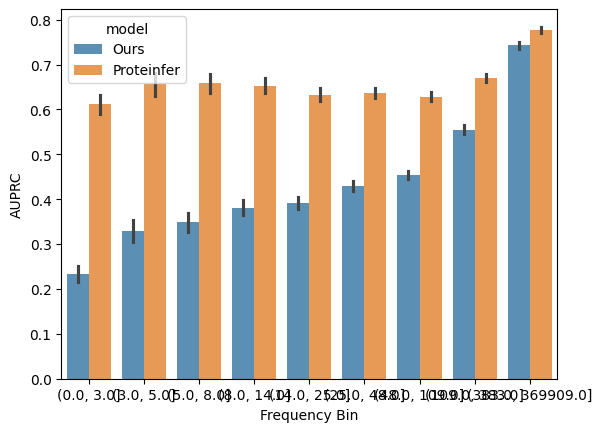

In [63]:
sns.barplot(data = res.reset_index(drop=True),
            x='Frequency Bin',
            y=metric,
            alpha=0.8,
            errorbar=('ci', 95),
            hue='model')

23.943886497688506
8.06631595727722
8.305435995536426
9.995217599234817
10.004782400765183
9.749721026622032
9.947393591582975
10.007970667941974
9.979276263350869


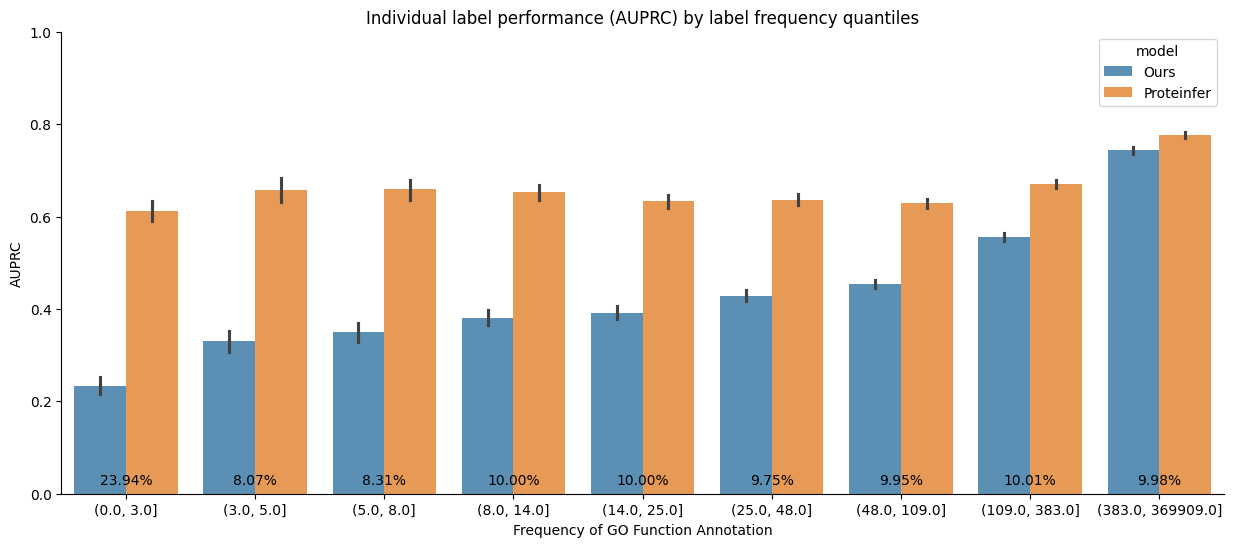

In [64]:
metric = 'AUPRC'

fig, ax = plt.subplots(figsize=(15,6))

# Annotate bars with the percentage of observations
for index, value in enumerate(freq_bins_pct.sort_index().values):
    print(value)
    ax.text(index, ax.get_ylim()[1]*0.01 + max(res[metric]) * 0.01, f"{value:.2f}%", ha='center')


sns.barplot(data = res.reset_index(drop=True),
            x='Frequency Bin',
            y=metric,
            alpha=0.8,
            errorbar=('ci', 95),
            hue='model')
ax.set(title=f'Individual label performance ({metric}) by label frequency quantiles',
       xlabel='Frequency of GO Function Annotation',
       ylabel=metric)
sns.despine()
plt.ylim(0,1)
plt.show()

In [42]:
res_ours = res.loc[res['model']=='Ours']
res_pinf = res.loc[res['model']=='Proteinfer']

res_ours[res_ours['AUPRC']>=0.9].sort_values(by='Frequency',ascending=False)

,AUPRC,model,Frequency,Frequency Bin
GO:0003674,0.996090,Ours,369909.0,"(383.0, 369909.0]"
GO:0008150,0.988887,Ours,346677.0,"(383.0, 369909.0]"
GO:0005575,0.993006,Ours,321980.0,"(383.0, 369909.0]"
GO:0009987,0.983003,Ours,295442.0,"(383.0, 369909.0]"
GO:0044464,0.986674,Ours,291432.0,"(383.0, 369909.0]"
...,...,...,...,...
GO:1905067,1.000000,Ours,1.0,"(0.0, 3.0]"
GO:1904964,1.000000,Ours,1.0,"(0.0, 3.0]"
GO:0086044,1.000000,Ours,1.0,"(0.0, 3.0]"
GO:0086054,1.000000,Ours,1.0,"(0.0, 3.0]"


In [43]:
res_ours[res_ours['AUPRC']>=0.9][['AUPRC','Frequency']].mean()

AUPRC           0.966465
Frequency    8255.058458
dtype: float64

In [44]:
res_pinf[res_pinf['AUPRC']>=0.9].sort_values(by='Frequency',ascending=False)

,AUPRC,model,Frequency,Frequency Bin
GO:0003674,0.994481,Proteinfer,369909.0,"(383.0, 369909.0]"
GO:0008150,0.983664,Proteinfer,346677.0,"(383.0, 369909.0]"
GO:0005575,0.992867,Proteinfer,321980.0,"(383.0, 369909.0]"
GO:0009987,0.980420,Proteinfer,295442.0,"(383.0, 369909.0]"
GO:0044464,0.986555,Proteinfer,291432.0,"(383.0, 369909.0]"
...,...,...,...,...
GO:1904025,1.000000,Proteinfer,1.0,"(0.0, 3.0]"
GO:0033841,1.000000,Proteinfer,1.0,"(0.0, 3.0]"
GO:0090425,1.000000,Proteinfer,1.0,"(0.0, 3.0]"
GO:0021837,1.000000,Proteinfer,1.0,"(0.0, 3.0]"


In [45]:
res_pinf[res_pinf['AUPRC']>=0.9][['AUPRC','Frequency']].mean()

AUPRC           0.988498
Frequency    1798.803335
dtype: float64

In [109]:
res_pinf.loc[res_ours[res_ours['AUPRC']>=0.8].index]['AUPRC'].mean()

0.9623318579385053

In [55]:


ground_truth = torch.tensor(val_labels.values)
preds = torch.tensor(val_probabilities.values)
sp = AveragePrecision(task="multilabel",num_labels=val_labels.shape[-1],average='macro').to('cuda')(preds,ground_truth).item()

/anaconda/envs/protein_functions_310/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)  # noqa: B028


In [56]:
ground_truth = torch.tensor(val_labels[items].values)
preds = torch.tensor(val_probabilities[items].values)
APMicro = AveragePrecision(task="multilabel",num_labels=len(items),average='micro').to('cuda')(preds,ground_truth).item()

0.3073350787162781

In [37]:
from torchmetrics.classification import AveragePrecision,Specificity
import torch
from tqdm import tqdm

total = 0
avg = 0
for group,items in tqdm(gb.groups.items()):
    print(group)
    ground_truth = torch.tensor(val_labels[items].values)
    preds = torch.tensor(val_probabilities[items].values)
    APMicro = AveragePrecision(task="multilabel",num_labels=len(items),average='micro').to('cuda')(preds,ground_truth).item()
    print(APMicro)
    w = res.loc[items].iloc[0]["Frequency Bin Percentage Of Data"]
    total +=

  0%|          | 0/8 [00:00<?, ?it/s]

(0.0, 2.0]


 12%|█▎        | 1/8 [00:27<03:11, 27.30s/it]

0.03821170702576637
(2.0, 3.0]


 25%|██▌       | 2/8 [00:33<01:28, 14.73s/it]

0.08802614361047745
(3.0, 4.0]


 38%|███▊      | 3/8 [00:37<00:50, 10.01s/it]

0.1348007619380951
(4.0, 7.0]


 50%|█████     | 4/8 [00:45<00:36,  9.04s/it]

0.18367116153240204
(7.0, 12.0]


 62%|██████▎   | 5/8 [00:51<00:24,  8.19s/it]

0.26992666721343994
(12.0, 25.0]


 75%|███████▌  | 6/8 [00:58<00:15,  7.82s/it]

0.3848440647125244
(25.0, 75.0]


 88%|████████▊ | 7/8 [01:06<00:07,  7.70s/it]

0.57602459192276
(75.0, 39034.0]


100%|██████████| 8/8 [01:14<00:00,  9.29s/it]

0.9135285019874573
